# DS 422 Final Project

## Name: Victor Agaba

## Date: 2023-05-12

***

The goal of this project is to compare different solution methods:

Gradient descent vs Grid search

In [48]:
# import required packages
from numpy import *
import matplotlib.pyplot as plt
import seismic_model as sm
import minimize_objective as mo
from obspy.taup import TauPyModel
import functions as fx
import importlib
from time import time

In [49]:
import os
os.getcwd()

'c:\\Users\\18723\\Documents\\GitHub\\SURG-Mars'

Original sdr:  [349.80684364  42.35375567 -18.91855175]


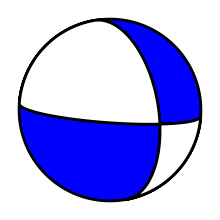

In [50]:
random.seed(422)

# create random array for t, normalised to 1
t = random.rand(3)
t /= linalg.norm(t)

# create random array for p, normalised to 1
direc = random.rand(3)
direc /= linalg.norm(direc)
p = fx.starting_direc(t, direc)

# get sdr for test case
sdr = fx.my_tp2sdr(t, p, True)[0]
print('Original sdr: ', sdr)

# plot corresponding beachball
beachball = fx.beachball(sdr)

In [51]:
# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
alpha, beta = 5.8000, 3.4600
b3_over_a3 = (beta/alpha)**3
Ao = array(fx.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta]))

***
#### 1. Gradient descent with backtracking linesearch
***

In [52]:
# initialize with notation from project description
phi = deg2rad(azimuth)
i, j = takeoff_angles
i, j = deg2rad(i), deg2rad(j)
d = Ao

In [53]:
# set up optimization problem
my_model = sm.SeismicModel(phi, i, j, alpha, beta, d)

# initialize options for gradient descent
options = mo.init_options()
options['output_level'] = 2
options['tol'] = 1e-5

# make initial guess
x_start = array([1,2,3])

# run with the default initial guess (0)
start_time = time()
status, m_sol, E_sol = mo.minimize(my_model, options, x_start=x_start)
end_time = time()
duration = end_time - start_time

Running gradient_descent method with backtracking line search at step size 1

  iter                       f   ||d_k||     alpha  # func   perturb  ||grad||
     0 -9.2823853851297922e-01  0.00e+00  0.00e+00       0  0.00e+00  1.09e+00
     1 -9.3949495175794806e-01  1.09e+00  2.50e-01       3  0.00e+00  6.18e-01
     2 -9.8952361488096041e-01  6.18e-01  2.50e-01       3  0.00e+00  8.97e-02
     3 -9.9135524913224971e-01  8.97e-02  5.00e-01       2  0.00e+00  1.79e-01
     4 -9.9465530610503883e-01  1.79e-01  2.50e-01       3  0.00e+00  1.11e-01
     5 -9.9539890444337320e-01  1.11e-01  2.50e-01       3  0.00e+00  1.39e-01
     6 -9.9700121194559399e-01  1.39e-01  2.50e-01       3  0.00e+00  1.14e-01
     7 -9.9803765111385279e-01  1.14e-01  1.25e-01       4  0.00e+00  4.41e-02
     8 -9.9945900896954820e-01  4.41e-02  1.00e+00       1  0.00e+00  1.06e-01
     9 -9.9989550957587658e-01  1.06e-01  1.25e-01       4  0.00e+00  3.88e-02
  iter                       f   ||d_k||     alpha  #

Best sdr:  [ 62.17051614 118.72464772 179.72519314]
Cosine similarity:  0.9999999999886985
Duration:  0.029996156692504883


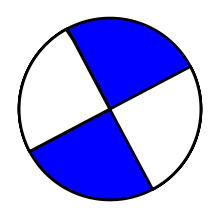

In [54]:
# print results
m_deg = rad2deg(m_sol)
print('Best sdr: ', m_deg)
print('Cosine similarity: ', -E_sol)
print('Duration: ', duration)

# plot corresponding beachball
beachball = fx.beachball(m_deg)

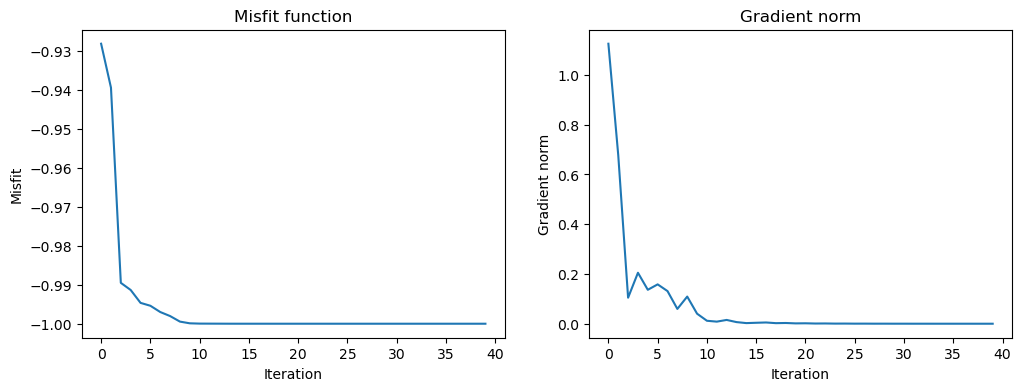

In [55]:
# plot the misfit and gradient norm
my_model.plot_misfit()

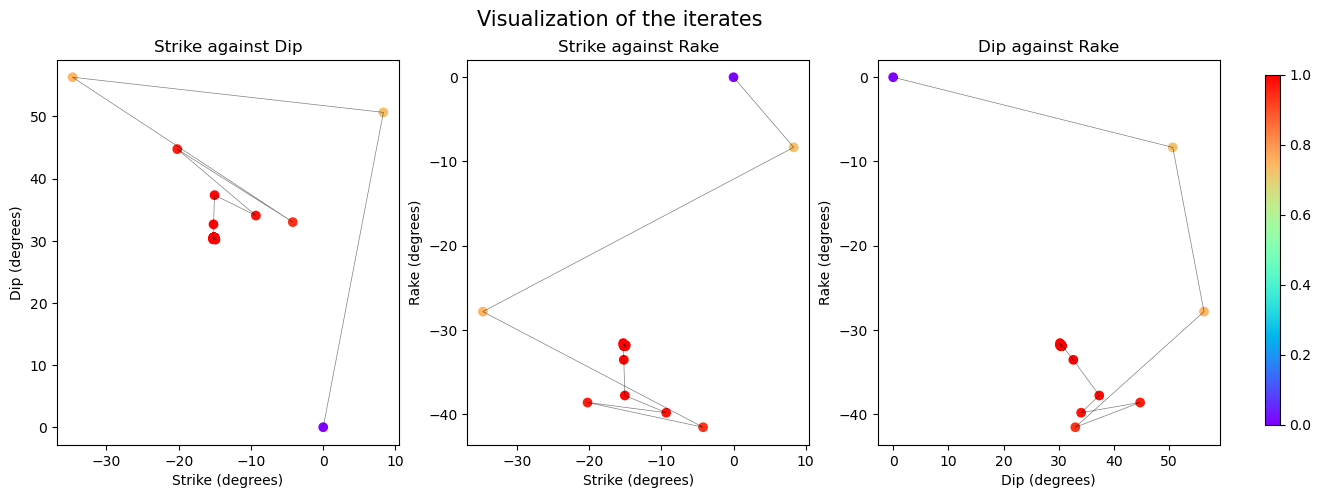

In [25]:
# plot the iterates
importlib.reload(sm)
my_model.plot_iterates()

In [27]:
importlib.reload(fx)

# compare m_sol with d using R_pattern
g = fx.Rpattern(m_deg, azimuth, takeoff_angles, [alpha, beta])

# get cosine similarity
cossim = fx.cossim(g, d)
if abs(cossim - 1) < 1e-5:
    print('Solution verified!')
else:
    print("Something's not right...")

Solution verified!


***
#### 2. Standard grid search
***

In [34]:
importlib.reload(fx)

# test the function
start_time = time()
best_sdr, best_misfit = fx.grid_search(4, Ao, azimuth, takeoff_angles, alpha, beta)
end_time = time()
duration = end_time - start_time

Solution found in 57375 iterations.


Best sdr:  [  94.79344565   76.9855089  -129.20626984]
Cosine similarity:  0.9999401702731692
Duration:  9.227191925048828


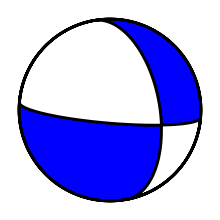

In [35]:
# see results
print('Best sdr: ', best_sdr)
print('Cosine similarity: ', -best_misfit)
print('Duration: ', duration)

# plot corresponding beachball
beachball = fx.beachball(best_sdr)

In [810]:
# compare best_sdr with Ao using R_pattern
As = fx.Rpattern(best_sdr, azimuth, takeoff_angles, [alpha, beta])

# get cosine similarity
cossim = fx.cossim(As, Ao)
if abs(cossim - 1) < 1e-5:
    print('Solution verified!')
else:
    print("Something's not right...")

Solution verified!


***
#### 3. Hierarchical grid search
***

In [36]:
importlib.reload(fx)

# test and time the function
start_time = time()
# note that spacing is more important than zooming
best_sdr, best_misfit = fx.hierarchical_grid_search(30, 4, Ao, azimuth, takeoff_angles, alpha, beta)
end_time = time()
duration = end_time - start_time

Solution found in 108000 iterations.


Best sdr:  [149.07384401  86.87127354 -34.19209442]
Cosine similarity:  0.9999979252124844
Duration:  3.4605553150177


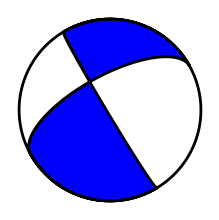

In [46]:
from obspy.imaging.beachball import beachball

# see results
print('Best sdr: ', best_sdr)
print('Cosine similarity: ', -best_misfit)
print('Duration: ', duration)

# plot corresponding beachball
beach_ball = fx.beachball(best_sdr)

In [47]:
# compare best_sdr with Ao using R_pattern
As = fx.Rpattern(best_sdr, azimuth, takeoff_angles, [alpha, beta])

# get cosine similarity
cossim = fx.cossim(As, Ao)
if abs(cossim - 1) < 1e-5:
    print('Solution verified!')
else:
    print("Something's not right...")

Solution verified!
